In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data



In [0]:
import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# SVHN training datasets
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)


Using downloaded and verified file: data/train_32x32.mat


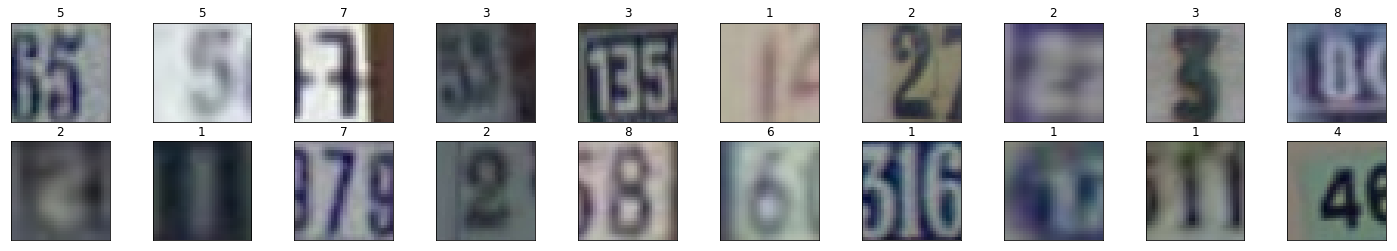

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Pre-processing: scaling from -1 to 1



In [0]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0549)
Max:  tensor(0.6863)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [0]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8902)
Scaled max:  tensor(0.3725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out
    

## Generator


In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [0]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out
    

## Build complete network



In [0]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU


In [0]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


---
## Discriminator and Generator Losses


In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
import torch.optim as optim

# params
lr = 0.0001
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training


In [0]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)

        # train the discriminator
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        

        # train the generator
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': d_loss}, 
            '/discriminator.pth')
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': G.state_dict(),
        'optimizer_state_dict': g_optimizer.state_dict(),
        'loss': g_loss}, 
        '/generator.pth')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3972 | g_loss: 0.8703
Epoch [    1/  100] | d_loss: 0.2024 | g_loss: 2.9705
Epoch [    2/  100] | d_loss: 0.3119 | g_loss: 2.4936
Epoch [    2/  100] | d_loss: 0.4661 | g_loss: 3.0041
Epoch [    3/  100] | d_loss: 0.4273 | g_loss: 2.4449
Epoch [    3/  100] | d_loss: 0.6158 | g_loss: 1.9110
Epoch [    4/  100] | d_loss: 0.7327 | g_loss: 1.4071
Epoch [    4/  100] | d_loss: 0.8362 | g_loss: 1.2036
Epoch [    5/  100] | d_loss: 0.5639 | g_loss: 1.8259
Epoch [    5/  100] | d_loss: 1.4017 | g_loss: 1.7162
Epoch [    6/  100] | d_loss: 0.9027 | g_loss: 2.5267
Epoch [    6/  100] | d_loss: 0.6210 | g_loss: 2.6164
Epoch [    7/  100] | d_loss: 0.4922 | g_loss: 1.9380
Epoch [    7/  100] | d_loss: 0.6528 | g_loss: 2.0369
Epoch [    8/  100] | d_loss: 0.4578 | g_loss: 2.2991
Epoch [    8/  100] | d_loss: 0.5802 | g_loss: 2.2715
Epoch [    9/  100] | d_loss: 0.5224 | g_loss: 2.1474
Epoch [    9/  100] | d_loss: 0.3142 | g_loss: 1.3615
Epoch [   10/  100] | d_loss

## Training loss



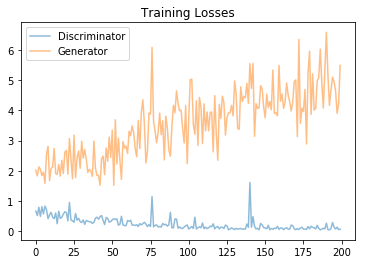

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Loading saved state of discrimintor



In [0]:
D_load = Discriminator(conv_dim)
d_optimizer_load = optim.Adam(D.parameters(), lr, [beta1, beta2])

In [0]:
checkpoint_d = torch.load('drive/My Drive/data /discriminator.pth')

In [0]:
D_load.load_state_dict(checkpoint_d['model_state_dict'])
d_optimizer_load.load_state_dict(checkpoint_d['optimizer_state_dict'])
epoch = checkpoint_d['epoch']
loss = checkpoint_d['loss']

D_load.eval()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

### Loading saved state of generator

In [0]:
G_load = Generator(z_size=z_size, conv_dim=conv_dim)
g_optimizer_load = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [0]:
checkpoint_g = torch.load('drive/My Drive/data /generator.pth')

In [0]:
G_load.load_state_dict(checkpoint_g['model_state_dict'])
g_optimizer_load.load_state_dict(checkpoint_g['optimizer_state_dict'])
epoch = checkpoint_g['epoch']
loss = checkpoint_g['loss']

G_load.eval()

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

## Generator samples from training



In [0]:
z = np.random.uniform(-1, 1, size=(batch_size, z_size))
z = torch.from_numpy(z).float()

In [0]:
G_load.cuda()

if train_on_gpu:
    z = z.cuda()
fake_image = G_load(z)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
images = fake_image

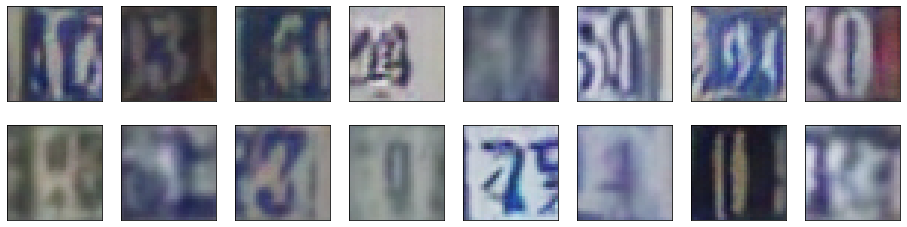

In [0]:
view_samples(-1, [images])

In [0]:
D_load.cuda()
D_output = D_load(fake_image[0:2])

In [0]:
D_output

tensor([[-4.9433],
        [-2.5287]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
D_load.fc

Linear(in_features=2048, out_features=1, bias=True)

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

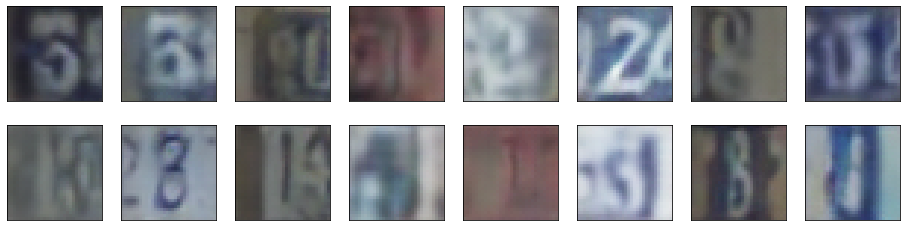

In [0]:
_ = view_samples(-1, samples)